### Описание задачи
Одним из самых ценных источников информации о клиенте являются данные о банковских транзакциях. В этом соревновании участникам предлагается ответить на вопрос: возможно ли предсказать пол клиента, используя сведения о поступлениях и тратах по банковской карте? И если возможно, то какая точность такого предсказания?

### Формальная постановка задачи
Необходимо предсказать вероятность пола "1" для каждого "customerid", который присутствует в файле gender_test_kaggle_sample_submission.csv.

### Метрика качества
В качестве метрики качества предсказания была выбрана ROC AUC (area under the receiver operating characteristic curve).


### File descriptions
transactions.csv - таблица содержит историю транзакций клиентов банка за один год и три месяца.

gender_train.csv - таблица содержит информацию по полу для части клиентов, для которых он известен.

tr_mcc_codes.csv - таблица содержит описание mcc-кодов транзакций.

tr_types.csv - таблица содержит описание типов транзакций.

gender_test_kaggle_sample_submission.csv - пример файла для загрузки решения.
### Data fields
#### transactions.csv
customer_id - идентификатор клиента

tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)

mcc_code - mcc-код транзакции

tr_type - тип транзакции

amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту (приходная транзакция), "-" — списание средств (расходная транзакция)

term_id - идентификатор терминала
#### gender_train.csv
customer_id - идентификатор клиента

gender - пол клиента
#### tr_mcc_codes.csv
mcc_code - mcc-код транзакции

mcc_description - описание mcc-кода транзакции
#### tr_types.csv
tr_type - тип транзакции

tr_description - описание типа транзакции

#### gender_test_kaggle_sample_submission.csv

customer_id - идентификатор клиента

probability - вероятность принадлежности к полу "1"

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import roc_curve,accuracy_score, roc_auc_score, confusion_matrix, f1_score

from tqdm.notebook import tqdm
tqdm.pandas()

import re

from tqdm.notebook import tqdm_notebook

import seaborn as sns
import scipy

### Знакомство с данными

In [2]:
# читаем данные
gender_train = pd.read_csv('D:/Files/alfa/gender_train.csv')
tr_mcc_codes = pd.read_csv('D:/Files/alfa/tr_mcc_codes.csv', sep=';')
tr_types = pd.read_csv('D:/Files/alfa/tr_types.csv', sep=';')
transactions = pd.read_csv('D:/Files/alfa/transactions.csv', sep=',')
gender_test = pd.read_csv('D:/Files/alfa/gender_test_kaggle_sample_submission.csv')

### Сводные таблицы

In [3]:
df_train = transactions.merge(gender_train, on='customer_id', how='left')
df_test = df_train .query('customer_id in @gender_test.customer_id')
df_test = df_test.drop('gender', axis=1)
df_test = df_test.set_index('customer_id')
gender_train = gender_train.set_index('customer_id')
df_train = df_train.set_index('customer_id')

In [4]:
df_train

,tr_datetime,mcc_code,tr_type,amount,term_id,gender
customer_id,,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,NaN,1.0
39026145,1 10:19:29,6011,7010,56147.89,NaN,1.0
39026145,1 10:20:56,4829,2330,-56147.89,NaN,1.0
39026145,1 10:39:54,5499,1010,-1392.47,NaN,1.0
39026145,2 15:33:42,5499,1010,-920.83,NaN,1.0
...,...,...,...,...,...,...
61870738,453 16:03:02,5499,1010,-5176.84,10217113,0.0
61870738,454 10:54:60,5411,1010,-1652.77,022915,0.0
61870738,454 14:23:59,5499,1010,-4687.23,10217113,0.0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849346 entries, 39026145 to 61870738
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   tr_datetime  object 
 1   mcc_code     int64  
 2   tr_type      int64  
 3   amount       float64
 4   term_id      object 
 5   gender       float64
dtypes: float64(2), int64(2), object(2)
memory usage: 365.8+ MB


### Графики

Text(0.5, 0, 'Пол клиента')

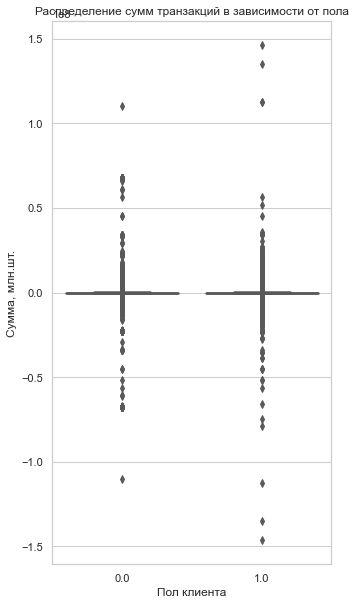

In [6]:
#построим ящики с усами 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5,10))

sns.boxplot(x='gender', y='amount',data=df_train, palette="Set2", linewidth=2.5)
plt.title('Распределение сумм транзакций в зависимости от пола')
plt.ylabel('Сумма, млн.шт.')
plt.xlabel('Пол клиента')


Text(0.5, 0, 'Пол клиента')

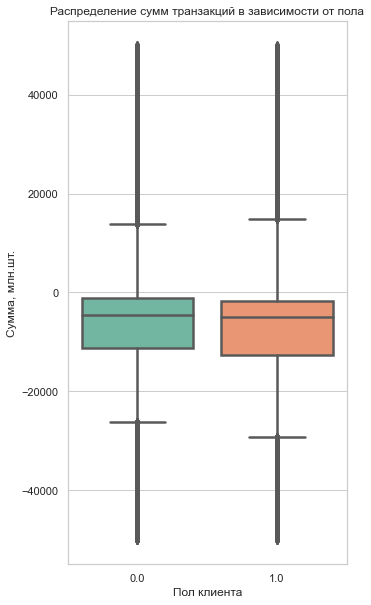

In [7]:
#построим ящики с усами предварительно обрезав выбросы
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5,10))

sns.boxplot(x='gender', y='amount',data=df_train[(df_train['amount']>-50000) & (df_train['amount']<50000)], palette="Set2", linewidth=2.5)
plt.title('Распределение сумм транзакций в зависимости от пола')
plt.ylabel('Сумма, млн.шт.')
plt.xlabel('Пол клиента')

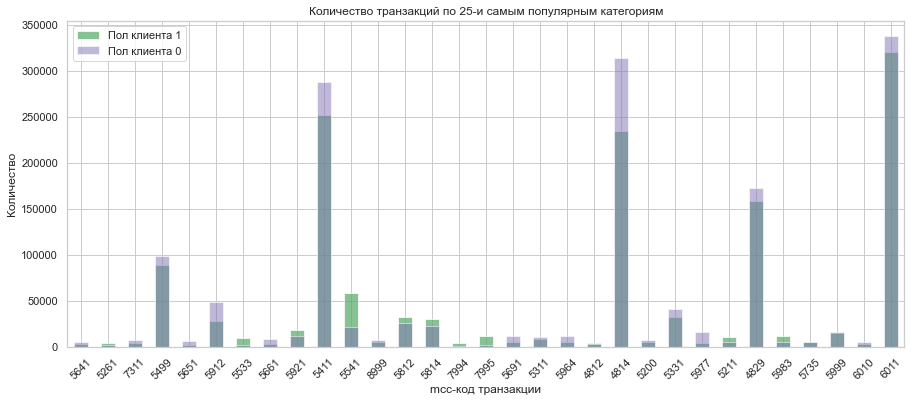

In [8]:
a = df_train[(df_train['gender']==1) & (df_train['amount']<0)].groupby('mcc_code')['mcc_code'].count().sort_values(ascending=False).head(25)
b = df_train[(df_train['gender']==0) & (df_train['amount']<0)].groupby('mcc_code')['mcc_code'].count().sort_values(ascending=False).head(25)
list_names = list(a.index)
name_b = list(b.index)
list_names.extend(name_b)
list_names = list(set(list_names))
a = df_train[(df_train['gender']==1) & (df_train['amount']<0)].groupby('mcc_code')['mcc_code'].count().sort_values(ascending=False)[list_names]
b = df_train[(df_train['gender']==0) & (df_train['amount']<0)].groupby('mcc_code')['mcc_code'].count().sort_values(ascending=False)[list_names]

ax = a.plot(kind='bar',grid=True, rot=45, figsize=(15,6), color='g', alpha=0.7)
# plt.ylabel('Количество проданных копий, млн.шт.')
# plt.xlabel('Платформа')
# plt.show()

b.plot(kind='bar',grid=True, title='Количество транзакций по 25-и самым популярным категориям', rot=45, figsize=(15,6), color='m', alpha=0.5, ax=ax)

plt.ylabel('Количество')
plt.xlabel('mcc-код транзакции')
plt.legend(['Пол клиента 1','Пол клиента 0'])
plt.show()

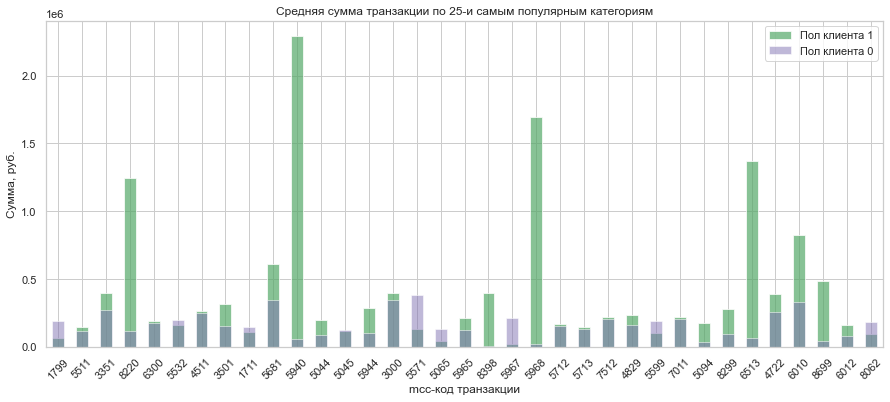

In [9]:
a = df_train[(df_train['gender']==1) & (df_train['amount']<0)].groupby('mcc_code')['amount'].mean().sort_values().head(25)
b = df_train[(df_train['gender']==0) & (df_train['amount']<0)].groupby('mcc_code')['amount'].mean().sort_values().head(25)

list_names = list(a.index)
name_b = list(b.index)
list_names.extend(name_b)
list_names = list(set(list_names))
a = -1*df_train[(df_train['gender']==1) & (df_train['amount']<0)].groupby('mcc_code')['amount'].mean()[list_names]
b = -1*df_train[(df_train['gender']==0) & (df_train['amount']<0)].groupby('mcc_code')['amount'].mean()[list_names]

ax = a.plot(kind='bar',grid=True, rot=45, figsize=(15,6), color='g', alpha=0.7)
# plt.ylabel('Количество проданных копий, млн.шт.')
# plt.xlabel('Платформа')
# plt.show()

b.plot(kind='bar',grid=True, title='Средняя сумма транзакции по 25-и самым популярным категориям', rot=45, figsize=(15,6), color='m', alpha=0.5, ax=ax)

plt.ylabel('Сумма, руб.')
plt.xlabel('mcc-код транзакции')
plt.legend(['Пол клиента 1','Пол клиента 0'])
plt.show()

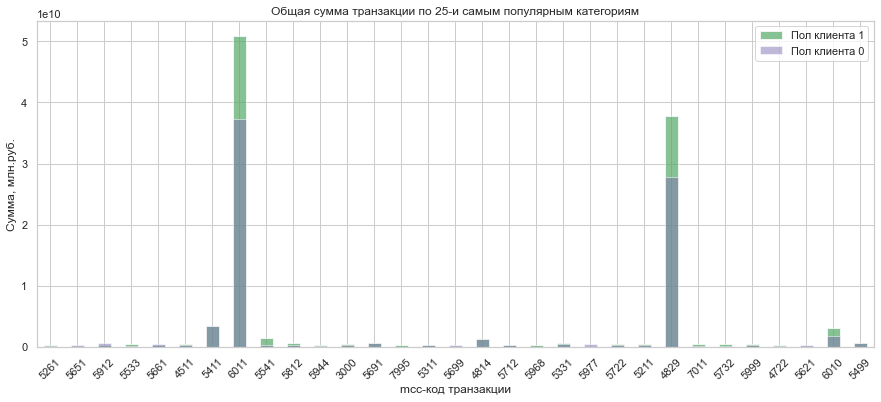

In [10]:
a = df_train[(df_train['gender']==1) & (df_train['amount']<0)].groupby('mcc_code')['amount'].sum().sort_values().head(25)
b = df_train[(df_train['gender']==0) & (df_train['amount']<0)].groupby('mcc_code')['amount'].sum().sort_values().head(25)

list_names = list(a.index)
name_b = list(b.index)
list_names.extend(name_b)
list_names = list(set(list_names))
a = -1*df_train[(df_train['gender']==1) & (df_train['amount']<0)].groupby('mcc_code')['amount'].sum()[list_names]
b = -1*df_train[(df_train['gender']==0) & (df_train['amount']<0)].groupby('mcc_code')['amount'].sum()[list_names]

ax = a.plot(kind='bar',grid=True, rot=45, figsize=(15,6), color='g', alpha=0.7)
# plt.ylabel('Количество проданных копий, млн.шт.')
# plt.xlabel('Платформа')
# plt.show()

b.plot(kind='bar',grid=True, title='Общая сумма транзакции по 25-и самым популярным категориям', rot=45, figsize=(15,6), color='m', alpha=0.5, ax=ax)

plt.ylabel('Сумма, млн.руб.')
plt.xlabel('mcc-код транзакции')
plt.legend(['Пол клиента 1','Пол клиента 0'])
plt.show()

### Подготовка данных и генерация признаков

In [11]:
df_train.dropna(subset=['gender'], inplace = True)

In [12]:
df_train = df_train.drop_duplicates()

In [13]:
for df in [df_train,df_test]:
    df['month'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) // 30)
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

df_train.head()

C:\Users\rk\anaconda3\envs\Tens\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,tr_datetime,mcc_code,tr_type,amount,term_id,gender,month,day,hour,night
customer_id,,,,,,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,NaN,1.0,0,0,10,-2
39026145,1 10:19:29,6011,7010,56147.89,NaN,1.0,0,1,10,-2
39026145,1 10:20:56,4829,2330,-56147.89,NaN,1.0,0,1,10,-2
39026145,1 10:39:54,5499,1010,-1392.47,NaN,1.0,0,1,10,-2
39026145,2 15:33:42,5499,1010,-920.83,NaN,1.0,0,2,15,-2


In [14]:
# добавим относительное кол-во транзакций час, день, месяц
# также данные о распределении расходов и доходов
# частоту появления кодов транзакцй

tqdm_notebook.pandas(desc="Progress:")

def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['month'].value_counts(normalize=True).add_prefix('month_')))
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
#     features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    
  
    
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('negative_transactions_')))
    
    

    features.append(pd.Series(x['mcc_code'].value_counts(normalize = True).add_prefix('mcc_count_')))
    
    return pd.concat(features)

In [15]:
data_train = df_train.groupby(df_train.index).progress_apply(features_creation_advanced).unstack(-1)
data_test = df_test.groupby(df_test.index).progress_apply(features_creation_advanced).unstack(-1)

target = data_train.join(gender_train, how='inner')['gender']

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

In [16]:
# добавим разницу между суммой расходов и доходов
data_train['delta_sum'] = data_train['positive_transactions_sum'] + data_train['negative_transactions_sum']
data_test['delta_sum'] = data_test['positive_transactions_sum'] + data_test['negative_transactions_sum']

# data_train['delta_count'] = data_train['positive_transactions_count'] + data_train['negative_transactions_count']
# data_test['delta_count'] = data_test['positive_transactions_count'] + data_test['negative_transactions_count']


In [17]:
# расходы и доходы по месяцам трайн

df_month_pos = df_train[df_train['amount']>0].groupby([df_train[df_train['amount']>0].index,'month'])['amount'].sum().unstack().reset_index().set_index('customer_id')
df_month_pos.rename(columns=lambda x: 'month_pos_'+str(x), inplace=True)

df_month_neg = df_train[df_train['amount']<0].groupby([df_train[df_train['amount']<0].index,'month'])['amount'].sum().unstack().reset_index().set_index('customer_id')
df_month_neg.rename(columns=lambda x: 'month_neg_'+str(x), inplace=True)

data_train = data_train.merge(df_month_pos, on='customer_id', how='left')
data_train = data_train.merge(df_month_neg, on='customer_id', how='left')

In [18]:
# расходы и доходы по месяцам тест

df_month_pos = df_test[df_test['amount']>0].groupby([df_test[df_test['amount']>0].index,'month'])['amount'].sum().unstack().reset_index().set_index('customer_id')
df_month_pos.rename(columns=lambda x: 'month_pos_'+str(x), inplace=True)

df_month_neg = df_test[df_test['amount']<0].groupby([df_test[df_test['amount']<0].index,'month'])['amount'].sum().unstack().reset_index().set_index('customer_id')
df_month_neg.rename(columns=lambda x: 'month_neg_'+str(x), inplace=True)

data_test = data_test.merge(df_month_pos, on='customer_id', how='left')
data_test = data_test.merge(df_month_neg, on='customer_id', how='left')

In [19]:
# tr_type

df_sum_tr = df_train.groupby([df_train.index,'tr_type'])['amount'].count().unstack().reset_index().set_index('customer_id')
df_sum_tr.rename(columns=lambda x: 'sum_tr_'+str(x), inplace=True)

data_train = data_train.merge(df_sum_tr, on='customer_id', how='left')

df_sum_tr_test = df_test.groupby([df_test.index,'tr_type'])['amount'].count().unstack().reset_index().set_index('customer_id')
df_sum_tr_test.rename(columns=lambda x: 'sum_tr_'+str(x), inplace=True)

data_test = data_test.merge(df_sum_tr_test, on='customer_id', how='left')

In [20]:
# расходы по категориям

df_sum = df_train.groupby([df_train.index,'mcc_code'])['amount'].sum().unstack().reset_index().set_index('customer_id')
df_sum.rename(columns=lambda x: 'sum_'+str(x), inplace=True)

data_train = data_train.merge(df_sum, on='customer_id', how='left')

df_sum_test = df_test.groupby([df_test.index,'mcc_code'])['amount'].sum().unstack().reset_index().set_index('customer_id')
df_sum_test.rename(columns=lambda x: 'sum_'+str(x), inplace=True)

data_test = data_test.merge(df_sum_test, on='customer_id', how='left')

In [21]:
# средние расходы по категориям

df_sum = df_train.groupby([df_train.index,'mcc_code'])['amount'].mean().unstack().reset_index().set_index('customer_id')
df_sum.rename(columns=lambda x: 'mean_'+str(x), inplace=True)

data_train = data_train.merge(df_sum, on='customer_id', how='left')

df_sum_test = df_test.groupby([df_test.index,'mcc_code'])['amount'].mean().unstack().reset_index().set_index('customer_id')
df_sum_test.rename(columns=lambda x: 'mean_'+str(x), inplace=True)

data_test = data_test.merge(df_sum_test, on='customer_id', how='left')

In [22]:
# отношение суммы расходов по категории к среднему значению доходов

for i in df_train.mcc_code.unique():
    data_train[f'{i}_pos'] = data_train[f'sum_{i}']/data_train['positive_transactions_mean']

for i in df_train.mcc_code.unique():
    data_test[f'{i}_pos'] = data_test[f'sum_{i}']/data_test['positive_transactions_mean']

C:\Users\rk\anaconda3\envs\Tens\lib\site-packages\ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
C:\Users\rk\anaconda3\envs\Tens\lib\site-packages\ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


In [23]:
data_train.fillna(0, inplace=True)
data_test.fillna(0, inplace=True)


In [24]:
x_train, x_test, y_train, y_test = train_test_split(data_train, target, test_size=0.2, random_state=1)

In [25]:
# соотношение классов
y_train.value_counts()/y_train.shape[0]

0    0.559524
1    0.440476
Name: gender, dtype: float64

### Catboost

In [26]:
#функция для графиков roc
def graph(fpr,tpr,auc_roc):
    fig, ax = plt.subplots(figsize=(8,8))

    ax.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC-кривая')
    ax.grid(True)
    ax.set_facecolor('whitesmoke')
    add_titlebox(ax=ax, text=f'AUC_ROC = {auc_roc.round(3)}',x=0.8,y=0.25)

    plt.show()
    
#функция для подписей на графиках
def add_titlebox(ax, text, x,y):
    ax.text(x, y, text, horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='green', alpha=0.6),
        fontsize=12.5)
    return ax

# функция обновления таблицы результатов
def res_data(df, auc_roc, accuracy, target, predict, name):
    tn, fp, fn, tp = confusion_matrix(target,predict).ravel()
    df = df.append(pd.Series(data={'auc_roc':round(auc_roc,3), 'accuracy': round(accuracy,3), 'TP': tp, 'FP':fp}, name=name), ignore_index=False)
    return df

#функция для матрицы ошибок
def conf_matrix(target,predict):
    cm = pd.DataFrame(confusion_matrix(target,predict), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
    display(cm)

In [27]:
%%time
model_cat = CatBoostClassifier(loss_function='Logloss',iterations=1200, verbose=100)

# предсказание вероятностей`
model_cat.fit(x_train,y_train)
probabilities_test = model_cat.predict_proba(x_test)

Learning rate set to 0.019661
0:	learn: 0.6867112	total: 143ms	remaining: 2m 51s
100:	learn: 0.4916746	total: 7.56s	remaining: 1m 22s
200:	learn: 0.4428480	total: 15s	remaining: 1m 14s
300:	learn: 0.4125521	total: 22.3s	remaining: 1m 6s
400:	learn: 0.3888227	total: 29.7s	remaining: 59.1s
500:	learn: 0.3633163	total: 37.7s	remaining: 52.6s
600:	learn: 0.3386701	total: 45.7s	remaining: 45.5s
700:	learn: 0.3174506	total: 53.6s	remaining: 38.2s
800:	learn: 0.3002669	total: 1m 1s	remaining: 30.7s
900:	learn: 0.2831137	total: 1m 9s	remaining: 23.1s
1000:	learn: 0.2676111	total: 1m 17s	remaining: 15.4s
1100:	learn: 0.2530270	total: 1m 25s	remaining: 7.69s
1199:	learn: 0.2398173	total: 1m 33s	remaining: 0us
Wall time: 1min 34s


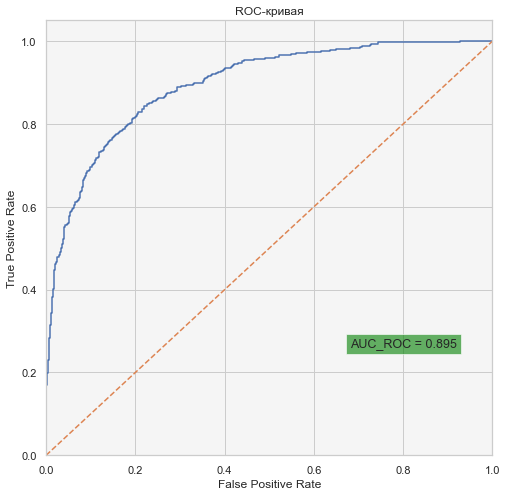

,predicted 0,predicted 1
actual 0,806,121
actual 1,193,560


In [28]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

#roc-кривая
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(y_test, predict_test)

### Важность признаков

In [29]:
importances = model_cat.feature_importances_
df_importances = pd.DataFrame(index=x_train.columns, columns=['importance'], data=importances).sort_values(by='importance',ascending=False)

df_importances.head(10)

,importance
mcc_count_5977,3.855117
mcc_count_5661,2.679880
mcc_count_5533,2.532397
mcc_count_5541,2.241610
mcc_count_5912,1.454400
mcc_count_4814,1.447835
mcc_count_6011,1.415766
mcc_count_5651,1.393870
delta_sum,1.387153
sum_5541,1.324693


In [30]:
x_faetures = df_importances[df_importances['importance']>0].index
len(x_faetures)

569

### Обучение модели с учетом важности признаков

In [31]:
%%time
model_cat = CatBoostClassifier(loss_function='Logloss',iterations=1200, verbose=100)

# предсказание вероятностей`
model_cat.fit(x_train[x_faetures],y_train)
probabilities_test = model_cat.predict_proba(x_test[x_faetures])


Learning rate set to 0.019661
0:	learn: 0.6865048	total: 67.9ms	remaining: 1m 21s
100:	learn: 0.4900941	total: 6.4s	remaining: 1m 9s
200:	learn: 0.4399150	total: 12.9s	remaining: 1m 4s
300:	learn: 0.4101135	total: 19.5s	remaining: 58.1s
400:	learn: 0.3861558	total: 26.4s	remaining: 52.7s
500:	learn: 0.3621190	total: 33s	remaining: 46s
600:	learn: 0.3381149	total: 39.4s	remaining: 39.3s
700:	learn: 0.3176460	total: 45.8s	remaining: 32.6s
800:	learn: 0.3001938	total: 52.2s	remaining: 26s
900:	learn: 0.2841726	total: 58.6s	remaining: 19.4s
1000:	learn: 0.2691993	total: 1m 4s	remaining: 12.9s
1100:	learn: 0.2553616	total: 1m 11s	remaining: 6.42s
1199:	learn: 0.2426598	total: 1m 17s	remaining: 0us
Wall time: 1min 18s


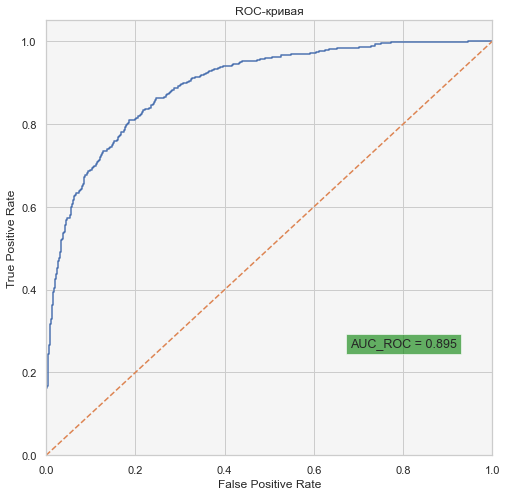

,predicted 0,predicted 1
actual 0,802,125
actual 1,200,553


In [32]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

#roc-кривая
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(y_test, predict_test)

### Итоговое обучение модели с учетом важности признаков

In [33]:
%%time
model_cat = CatBoostClassifier(loss_function='Logloss',iterations=10000, verbose=100)

Wall time: 1 ms


In [34]:
# предсказание вероятностей`
model_cat.fit(data_train[x_faetures],target)
probabilities_test = model_cat.predict_proba(data_test[x_faetures])

Learning rate set to 0.003095
0:	learn: 0.6920945	total: 71.7ms	remaining: 11m 56s
100:	learn: 0.6180512	total: 6.87s	remaining: 11m 13s
200:	learn: 0.5734697	total: 13.8s	remaining: 11m 11s
300:	learn: 0.5442489	total: 20.7s	remaining: 11m 6s
400:	learn: 0.5231049	total: 27.6s	remaining: 11m
500:	learn: 0.5066735	total: 34.5s	remaining: 10m 54s
600:	learn: 0.4938262	total: 41.4s	remaining: 10m 47s
700:	learn: 0.4832311	total: 48.3s	remaining: 10m 40s
800:	learn: 0.4738458	total: 55.2s	remaining: 10m 33s
900:	learn: 0.4658028	total: 1m 2s	remaining: 10m 27s
1000:	learn: 0.4585051	total: 1m 9s	remaining: 10m 20s
1100:	learn: 0.4518006	total: 1m 15s	remaining: 10m 13s
1200:	learn: 0.4458251	total: 1m 22s	remaining: 10m 6s
1300:	learn: 0.4404003	total: 1m 29s	remaining: 9m 59s
1400:	learn: 0.4351985	total: 1m 36s	remaining: 9m 52s
1500:	learn: 0.4304471	total: 1m 43s	remaining: 9m 45s
1600:	learn: 0.4259595	total: 1m 50s	remaining: 9m 38s
1700:	learn: 0.4216652	total: 1m 57s	remaining: 9m

In [35]:
gender_test1 = gender_test.drop('probability', axis=1)
data_test['probability'] = probabilities_test[:, 1]
result = gender_test1.join(data_test, on = 'customer_id', how='inner')
result = result[['customer_id','probability']]

In [36]:
result.to_csv('D:/Files/alfa/result_17.csv', index=False)